# Atuação em simulações de trânsito baseado na detecção de anomalias em trechos de vias

Neste Jupyter Notebook apresentaremos nossas análises a respeito do experimento
**"Atuação em simulações de trânsito baseado na detecção de anomalias em trechos
de vias"**.

Neste experimento nós avaliamos a atuação na simulação do tráfego de veículos,
sendo a atuação baseada na detecção de anomalias dos trechos das vias, utilizando PMVs
(placas de mensagens variadas) que alertarão motoristas sobre os trechos fechados,
permitindo com que melhores rotas sejam utilizadas. De maneira geral,

- Simulamos o trânsito de uma cidade

- Adicionamos eventos que fecham estradas durante a simulação

- Detectamos anomalias de trechos da cidade, baseado nos comportamentos anômalos que
alguns trechos passarão a ter após algumas estradas serem fechadas. Baseado nessa
detecção nós atuamos em placas de trânsito pré-posicionadas em alguns pontos da cidade,
alertando motoristas que passarem por esse ponto que certos trechos estão bloqueados

O experimento foi dividido em dois cenários: o primeiro, que chamamos de
**cenário de validação**, trata-se de um cenário reduzido e que nos ajudou a validar
os algoritmos implementados e ilustra como ocorrem as interações entre os diferentes
módulos de software utilizados. O segundo cenário, que chamamos de **cenário de São
Paulo**, apresenta uma simulação com dados reais da cidade de São Paulo, sendo
de mairo escala que o primeiro.

### Análise das simulações

Nossa análise será feita sobre os resultados emitidos pelo simulador [InterSCimulator](http://interscity.org/software/interscsimulator/), simulador que utilizamos para os experimentos. Após cada rodada de simulação
o simulador gera um arquivo `.csv` que contém pequenos detalhes sobre as viagens encerradas durante
a simulação. Na seção seguinte nós detalhamos os campos desses arquivos.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
from matplotlib import rc
COLUMNS = ["hour", "minute", "last_tick", "type", "trip_id", "last_link", "duration", "distance"]

### Descrição do arquivo resultante da simulação

Como dito, ao final da simulação são gerados arquivos que contém as **viagens finalizadas**. Esses arquivos, que estão em formato `csv`, contém os seguintes campos:

- **hour**: Em que hora começamos a executar aquela rodada de simulação                                                                                      
                                                                                                                                          
- **minute**: Em que minuto começamos a executar aquela rodada de simulação                                                                              
                                                                                                                                          
- **last_tick**: O último tick (instante de simulação) daquela viagem                                                                                                                           
                                                                                                                                          
- **type**: O tipo do dado no arquivo `.csv` (todas serão do tipo **arrival**)                                                                                                                            
                                                                                                                                          
- **trip_id**: O identificador daquela viagem                                                                                            
                                                                                                                                          
- **last_link**: A última aresta do grafo por onde aquela viagem passou (permite encontrar o destino final de uma viagem)                                                                                 
                                                                                                                                          
- **duration**: A duração total de uma viagem (ou seja, podemos inferir o início de uma viagem combinando a duração e o último tick)                                                                                  
                                                                                                                                          
- **distance**: A distância total percorrida durante uma viagem


# Análise 1 - Cenário de Validação

Inicialmente validamos o modelo de simulação de eventos de trânsito (e utilização de PMVs - Placas de Mensagem Variada) implementada no **InterSCSimulator**. Para isso utilizamos um contexto controlado, composto de um grafo simples e um número reduzido de viagens.

Separamos esse cenário em três fases, e em cada fase executamos vinte rodadas de simulação:

- Sem evento de fechamento de rua;

- Com um evento de fechamento de rua mas sem o auxílio de PMVs;

- Com um evento de fechamento de rua e auxílio de PMVs.

Executamos vinte (20) simulações de 10 minutos para cada fase, resultando em três conjuntos de dados (um por cenário) que continham a saída de todas essas rodadas de simulação. Ao final realizamos análises dos resultados gerados por essas simulações.

## Entrada do Cenário de Validação

A seguir descreveremos as duas entradas da simulação: a descrição do mapa da cidade e a lista de viagens.

### Mapa da Cidade

Utilizamos o grafo abaixo como mapa da cidade nos três cenários, composto de  8 vértices e 16 arestas. O grafo é apresentado como não-direcionado, mas na verdade é um grafo direcionado onde todos os vértices apresentados têm ida e volta:

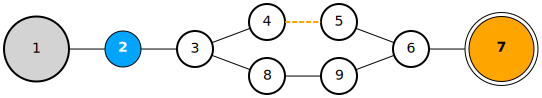

In [31]:
from graphviz import Graph

g = Graph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('2', fillcolor='#00A5FF', label='<<b>2</b>>', fontcolor='white', style='filled')  
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='orange', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')
        
g.edge('1', '2')
g.edge('2', '3')
g.edge('3', '4')
g.edge('4', '5', style='dashed, bold', color='orange')
g.edge('5', '6')
g.edge('3', '8')
g.edge('8', '9')
g.edge('9', '6')
g.edge('6', '7')
g

O grafo acima modela a cidade da seguinte forma:

- Os vértices representam início/fim de uma ou mais ruas (no grafo acima, por exemplo, os vértices 1 e 7 não são o encontro de ruas pois estão nos cantos e só uma aresta sai deles, mas os outros sim

- As arestas representam as ruas de uma cidade

- As arestas têm o mesmo tamanho (comprimento 1)

- A cada tick (etapa de simulação) os veículos andam uma aresta

Adotamos a seguinte nomenclatura para separar vértices e arestas especiais:

- A aresta amarela representa a rua da cidade onde ocorrerá o evento de fechamento de rua (nenhum veículo passará por essa aresta durante um evento) - essa aresta só será afetada no cenário com evento

- O vértice cinza representa a origem de todas as viagens simuladas

- O vértice amarelo representa o destino das viagens.

- O vértice azul representa o local da cidade que contém uma PMV que alertará os motoristas sobre o fechamento de ruas

### Lista de Viagens

Nos três cenários utilizamos um total de 100 viagens, que tinham como origem o `vértice 1` e como destino o `vértice 7`.

## Análise dos Dados

### Considerações Iniciais

Abaixo comparamos os valores de distância média dos três cenários. A nossa hipótese era que todos os veículos utilizassem o seguinte caminho no grafo apresentado anteriormente:

- No cenário **sem evento**, que o caminho fosse o apresentado abaixo. As arestas de cor roxa representam o caminho inicial calculado e o seguido pelos veículos (as arestas que não foram usadas foram ocultadas). Note que, quando no **vértice 3**, ele opta pelo **vértice 4**: o critério de desempate é qual vértice vem primeiro no arquivo de entrada, onde o montamos com os vértices de menor índice primeiro.

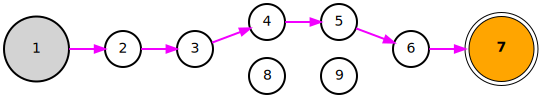

In [32]:
from graphviz import Digraph

g = Digraph('G')

g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='orange', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#F200FF')
g.edge('3', '4', style='bold', color='#F200FF')
g.edge('4', '5', style='bold', color='#F200FF')
g.edge('5', '6', style='bold', color='#F200FF')
g.edge('3', '8', style='invis')
g.edge('8', '9', style='invis')
g.edge('9', '6', style='invis')
g.edge('6', '7', style='bold', color='#F200FF')

g

- No cenário **com evento e sem PMV** que fosse utilizado o percurso no mapa abaixo. As arestas de **cor roxa** representam o caminho inicial que chegou a ser percorrido pelos veículos; as arestas de **cor preta** o caminho inicial calculado mas que não foi percorrido devido ao evento de trânsito na aresta `4 -> 5`; e as arestas de **cor verde** o caminho recalculado e percorrido após se deparar com a aresta proibida. A aresta proibida (`4 -> 5`) está tracejada.

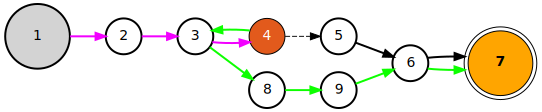

In [33]:
from graphviz import Digraph

g = Digraph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('3')
g.node('4', fillcolor='#E25A1C', fontcolor='white', style='filled')


g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='orange', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#F200FF')

g.edge('4', '3', style='bold', color='#0DFF00')
g.edge('3', '4', style='bold', color='#F200FF')
g.edge('4', '5', style='dashed')
g.edge('5', '6', style='bold')
g.edge('3', '8', style='bold', color='#0DFF00')
g.edge('8', '9', style='bold', color='#0DFF00')
g.edge('9', '6', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold')

g

* No cenário **com evento e com auxílio de PMV** que fosse utilizado o grafo abaixo. Novamente ocorre um evento de fechamento de trânsito na aresta `4 -> 5`, tornando-a proibida, contudo uma PMV posicionada no vértice 2 (cor azul) notifica os motoristas a respeito do evento, fazendo com que a rota seja recalculada previamente. Utilizamos a mesma notação, onde as arestas de **cor roxa** representam o caminho inicial que chegou a ser percorrido pelos veículos; as arestas de **cor preta** o caminho inicial calculado mas que não foi percorrido devido a notificação da PMV posicionada no vértice `2`; as arestas de **cor verde** representam o caminho recalculado e percorrido (agora recalculados pela notificação do PMV). A aresta proibida (`4 -> 5`) continua tracejada. Ainda, esperávamos que certos veículos utilizassem o mesmo caminho caso não houvesse PMV (ignorando as notificações), tendo resultado igual ao cenário citado anteriormente; cerca de `1/3` dos veículos que são notificados utilizam o novo caminho recalculado, e `2/3` utilizam o caminho inicial.

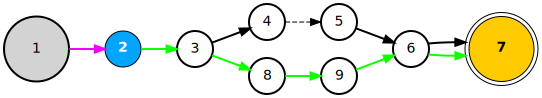

In [10]:
from graphviz import Digraph

g = Digraph('G')
g.attr(rankdir='LR', size='20', splines='true', ranksep='0.5')
g.attr('node', shape='circle', rankdir='LR', style='bold', fontname = "verdana")

g.node('1', style='filled,bold', fixedsize='true', width='.9')
g.node('2', fillcolor='#00A5FF', label='<<b>2</b>>', fontcolor='white', style='filled')  
g.node('3')
g.node('4')
g.node('5')
g.node('6')
g.node('7', shape='doublecircle', fillcolor='#FFCB00', label='<<b>7</b>>', fontcolor='black', style='filled', fixedsize='true', width='.9')
g.node('8')
g.node('9')

g.edge('1', '2', style='bold', color='#F200FF')
g.edge('2', '3', style='bold', color='#0DFF00')

g.edge('3', '4', style='bold')

g.edge('4', '5', style='dashed')
g.edge('5', '6', style='bold')
g.edge('3', '8', style='bold', color='#0DFF00')
g.edge('8', '9', style='bold', color='#0DFF00')
g.edge('9', '6', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold', color='#0DFF00')
g.edge('6', '7', style='bold')

g

### Resultados e Conclusões

Inicialmente, carregamos os conjuntos de dados construídos a partir das simulações realizadas. Daqui em diante chamaremos o cenário que não ocorre o evento de `baseline`, o cenário onde ocorre o evento mas que não possui PMV de `events` e o cenário onde ocorre o evento e há o auxílio de PMV de `pmv`:

In [3]:
# carregando os dados
baseline_dataset_path = "validation/datasets/baseline_scenario/output.csv"
events_dataset_path = "validation/datasets/events_scenario/output.csv"
pmv_dataset_path = "validation/datasets/pmv_scenario/output.csv"

baseline_df = (pd
    .read_csv(baseline_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

events_df = (pd
    .read_csv(events_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

pmv_df = (pd
    .read_csv(pmv_dataset_path, delimiter=";", header=None, names=COLUMNS)
    .assign(first_tick=lambda x: x['last_tick'] - x['duration']))

Em seguida, agrupamos as viagens (através do ``groupby``) utilizando o campo `last_link` (esse campo indica qual foi a última rua daquela viagem). Todas as viagens têm a mesma origem e destino, sendo agrupadas. Após, calculamos a média dos valores de todos os campos de um grupo. Ao final, no campo `duration` (duração da viagem) será apresentado a média da duração das viagens, no campo `distance` (distância da viagem) a média das distâncias da viagem, e assim sucessivamente.

In [12]:
df1 = (baseline_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Sem evento"))

df2 = (events_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Com evento"))

df3 = (pmv_df[['last_link', 'distance', 'duration']]
        .assign(scenario=r"Com evento e PMV"))

Após, construímos um conjunto de dados final composto da média dos três cenários apresentados (através do `append`). Nos preocupamos somente com os campos `last_link`, `distance` e `duration` pois serão os únicos campos usados na análise apresentada a seguir.

In [13]:
df = df1.append(df2).append(df3)

Por fim, abaixo apresentamos os resultados finais dos três cenários utilizando gráficos de barras. Segundo nossas hipóteses (os três caminhos apresentados anteriormente), esperávamos que o cenário **sem evento** percorresse 6 arestas, o cenário **com evento e sem PMV** percorresse 8 arestas e o cenário **com evento e PMV** percorresse entre 6 e 8 arestas (esperávamos que alguns veículos ignorassem as notificações). Nossas hipóteses foram confirmadas, conforme o gráfico abaixo.

No handles with labels found to put in legend.


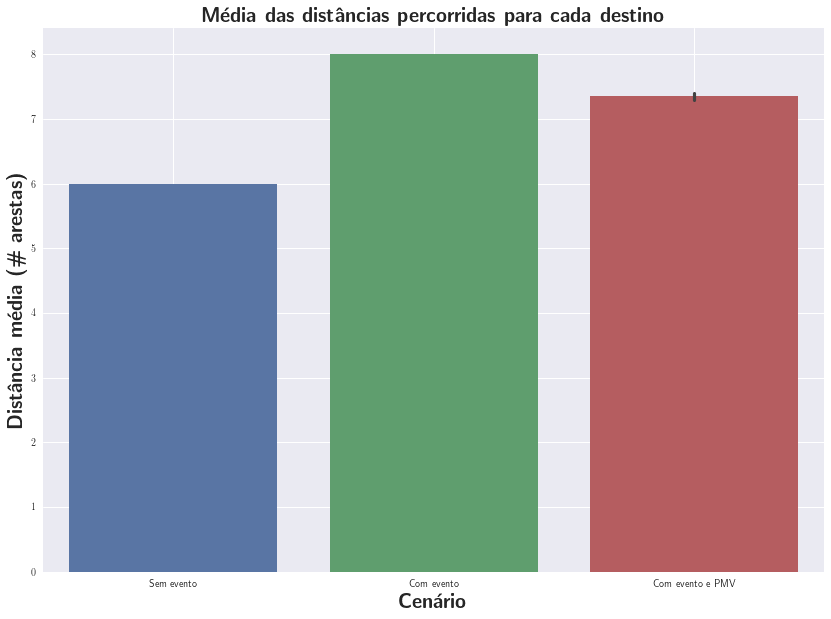

In [14]:
rc('text', usetex=True)
plt.figure(figsize=(14,10))

ax = sns.barplot(data=df, x='scenario', y='distance')

ax.set_xlabel(r'\textbf{Cen\'ario}', fontsize='20')
ax.set_ylabel(r'\textbf{Dist\^ancia m\'edia (\# arestas)}', fontsize='20')

plt.legend(loc="best",prop={"size":15})
plt.title(r"\textbf{M\'edia das dist\^ancias percorridas para cada destino}", size=20)
plt.grid(True)
sns.set(font_scale = 1.5)

plt.show()

Fizemos uma análise semelhante também para as durações das viagens, conforme apresentado no gráfico abaixo.

Uma viagem dura sempre 2 ticks mais o tempo utilizado para percorrer as arestas (uma aresta por tick) e o recálculo de um caminho custa um tick. Por isso, esperávamos agora que o cenário **sem evento** durasse 8 ticks (2+6 por terem 6 arestas), o cenário **com evento e sem PMV** durasse 11 ticks (2+8 arestas+1 pelo recálculo) e o cenário **com evento e PMV** durasse entre 9 e 11 ticks (2+8 arestas+1 pelo recálculo para os motoristas que ignorem o PMV e 2+6 arestas+1 para os motoristas que sigam a notificação do PMV). Nossas hipóteses foram confirmadas, conforme o gráfico abaixo.

No handles with labels found to put in legend.


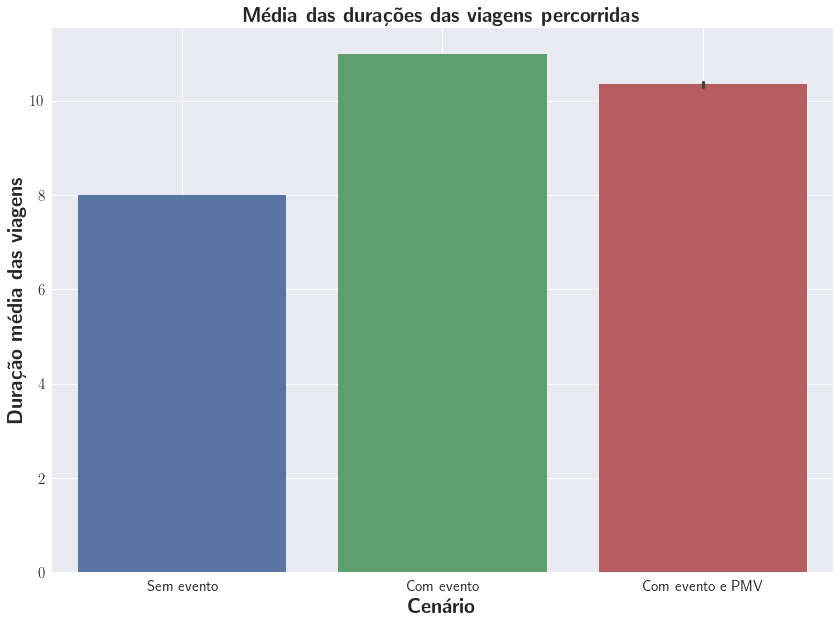

In [15]:
plt.figure(figsize=(14,10))

ax = sns.barplot(data=df, x='scenario', y='duration')

ax.set_xlabel(r'\textbf{Cen\'ario}', fontsize='20')
ax.set_ylabel(r'\textbf{Dura\c{c}\~ao m\'edia das viagens}', fontsize='20')

plt.legend(loc="best",prop={"size":15})
plt.title(r"\textbf{M\'edia das dura\c{c}\~oes das viagens percorridas}", size=20)
plt.grid(True)
sns.set(font_scale = 1.5)

plt.show()

Dessa forma, entendemos que tanto o modelo de trânsito quanto o modelo de PMVs implementados no InterSCSimulator são condizentes com o que esperávamos e que podiamos, de fato, utilizarmos num cenário maior.

# Análise 2 - Cenário de São Paulo

A seguir apresentaremos nossa análise para uma simulação com uma escala maior, que se assemelhe a cidade de São Paulo. Neste experimento utilizaremos parte do mapa real da cidade de São Paulo e como referência viagens da pesquisa Origem-Destino do ano de 2007. Adicionamos diversos eventos de fechamento de rua, localizados em dois conglomerados da cidade, perto de pontos bem ativos.

Assim como no cenário anterior, separamos esse cenário em três fases:

- Sem os eventos de fechamento de rua;

- Com os eventos de fechamento de rua mas sem o auxílio de PMVs;

- Com os eventos de fechamento de rua e o auxílio de 7 PMVs;

Executamos a simulação dessas três fases vinte (20) vezes e construímos três datasets (um por cenário) que continham a saída de todas essas rodadas de simulação.

## Entrada da Simulação

A seguir descreveremos as duas entradas da simulação do cenário realístico: a descrição do mapa da cidade e a lista de viagens.

### Mapa da Cidade

Utilizamos o mapa da cidade de São Paulo como grafo a ser utilizado na simulação. O mapa é um arquivo `xml` construído à partir do mapa real da cidade disponível no Open Street Map. Utilizamos uma parcela reduzida do mapa, com centro em `-23.5585875, -46.6686528` e abrangendo todas as arestas num raio de 5 Km. No notebook [Map Generator](https://github.com/LSS-USP/pmv_experiment/blob/master/utils/map_generator.ipynb), localizado em `utils/map_generator.ipynb`, explicamos como gerar um mapa semelhante para ser utilizado pelo simulador.

### Lista de Viagens

Utilizamos todas as viagens da pesquisa Origem Destino do ano de 2007 que tinham como origem e destino um vértice pertencente ao nosso mapa filtrado. No notebook [Filter Trips](https://github.com/LSS-USP/pmv_experiment/blob/master/utils/filter_trips.ipynb), localizado em `utils/filter_trips.ipynb`, explicamos como gerar um arquivo com as viagens filtradas, pronto para ser utilizado pelo simulador. Filtramos essas viagens pois não haveria caminho no grafo disponível no simulador.

### Eventos de Fechamento de Rua

Abaixo apresentamos onde posicionamos os eventos de fechamento de rua; todas as arestas apresentadas foram bloqueadas durante as simulações das etapas 2 e 3 desse segundo cenário do experimento. No notebook [Events Generator](https://github.com/LSS-USP/pmv_experiment/blob/master/utils/events_generator.ipynb), localizado em `utils/events_generator.ipynb`, explicamos como gerar um arquivo com os eventos de fechamento de rua, pronto para ser utilizado pelo simulador.

### Paineis de Mensagem Variada (PMVs)

Abaixo apresentamos os locais onde posicionamos as PMVs dos cenários simulados. No notebook [PMVs Generator](https://github.com/LSS-USP/pmv_experiment/blob/master/utils/pmvs_generator.ipynb) explicamos como procurar informações sobre os nós que abrigarão as PMVs. Decidimos posicionar as PMVs nas principais vias do nosso mapa reduzido, aumentando o impacto no trânsito.

![Mapa com PMVs](./img/pmvs_locations.png)

### Considerações Iniciais

Abaixo comparamos os valores de duração média de viagem dos três cenários simulados. Esperávamos que o cenário sem o evento fosse o limite inferior e o cenário com o evento (e sem PMVs) o limite superior. Ou seja: o cenário sem o evento deveria ser o que os motoristas **demorassem menos** em seus trajetos, percorrendo **distâncias menores**, e o com o evento que **demorassem mais**, percorrendo **distâncias maiores**. Entre esses dois limiares esperávamos que ficasse o **cenário com PMVs**.

### Resultados e Conclusões

Inicialmente, carregamos os três datasets gerados, cada um em um `dataframe`. Os datasets são os seguintes:

- Dataset 1: Deu origem ao dataframe `non_events` e apresenta uma simulação no cenário onde não ocorrem acidentes

- Dataset 2: Deu origem ao dataframe `events` e apresenta uma simulação no cenário onde ocorrem acidentes e não existem PMVs disponíveis

- Dataset 3: Deu origem ao dataframe `pmvs` e apresenta uma simulação no cenário onde ocorrem acidentes e existem as PMVs escolhidas

No campo `scenario` classificamos os `dataframes` e no final os unimos todos em um único `dataframe`, que chamamos de `datasets`.

In [41]:
NON_EVENTS_DATASET_PATH = 'new_paulista/datasets/baseline_scenario/rounds/output.csv'
EVENTS_DATASET_PATH = 'new_paulista/datasets/events_scenario/rounds/output.csv'
PMVS_DATASET_PATH = 'new_paulista/datasets/pmvs_scenario/rounds/output.csv'


non_events_df = (pd
    .read_csv(NON_EVENTS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(scenario="Sem Evento"))

events_df = (pd
    .read_csv(EVENTS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(scenario="Com Evento"))

pmvs_df = (pd
    .read_csv(EVENTS_PMVS_DATASET_PATH, delimiter=";", header=None, names=COLUMNS)
    .assign(scenario="Com Evento e PMVs"))

datasets = non_events_df.append(events_df).append(pmvs_df)

### Análise de todas as viagens

Abaixo apresentamos a análise das durações de todas as viagens entre os três conjuntos de dados.

No handles with labels found to put in legend.


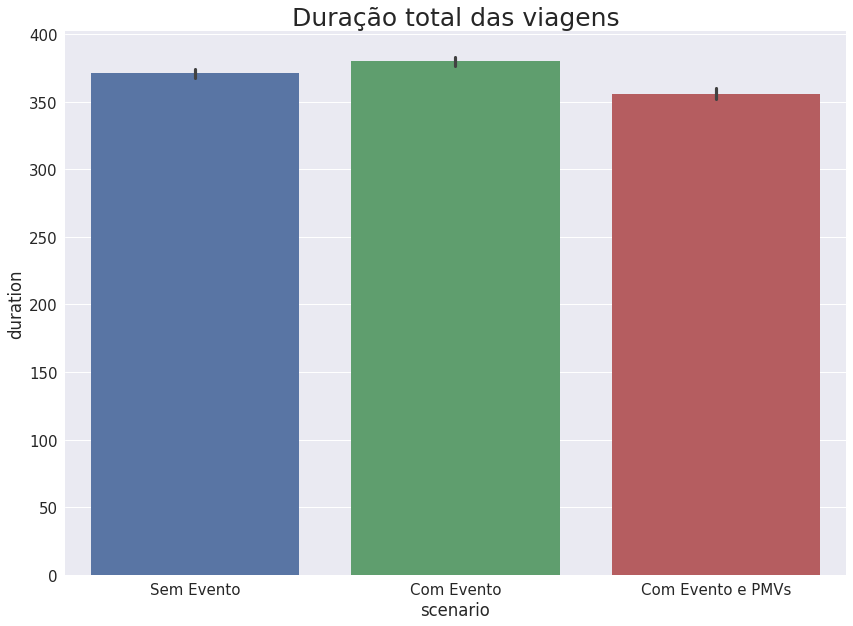

In [45]:
rc('text', usetex=False)

plt.figure(figsize=(14,10))

ax = sns.barplot(data=datasets, x='scenario', y='duration')

plt.legend(loc="best",prop={"size":20})
plt.title("Duração total das viagens", size=25)
sns.set(font_scale = 1.5)

plt.show()

Conforme o esperado, o cenário **com eventos e sem PMVs** foi, de fato, o mais lento dentre os três. Contudo, diferente do que esperávamos, o cenário **com eventos e PMVs** teve viagens mais rápidas que o **sem eventos**. Atribuímos esse resultado ao fato das placas promoverem uma melhor distribuição dos carros nas vias, pois enquanto alguns veículos irão recalcular os novos caminhos ao atingirem o PMV, outros só irão recalcular após chegarem a via que está fechada.

### Análise das viagens afetadas

Pelo mapa da cidade utilizado ser grande, um grande número de viagens não sofrem qualquer influência dos acidentes mas mesmo assim contribuíram para o cálculo que apresentamos no item anterior. Por esse motivo, fizemos uma análise semelhante a apresentada anteriormente, mas só levando em conta viagens que tiveram suas distâncias alteradas durante as simulações.

A função `trips_filter` recebe um grupo de percursos que representam a mesma viagem (tiveram a mesma origem e mesmo destino) e retorna somente viagens que tiveram variações nas distâncias. Após, utilizamos somente o campo de identificador da viagem e removemos os valores duplicados, montando um arranjo `affected_trips` com a lista de todas as viagens que foram afetadas pelos fechamentos de vias.

Ao final, filtramos o `dataframe` que continha todas as viagens, permanecendo agora somente as viagens afetadas.

In [62]:
def trips_filter(trip_id_group):
    if (trip_id_group.distance.nunique() > 1):
        return trip_id_group
    else:
        return None
    
affected_trips = datasets.groupby('trip_id').apply(trips_filter)['trip_id'].unique()

filtered_df = datasets[datasets.trip_id.isin(affected_trips)]

No handles with labels found to put in legend.


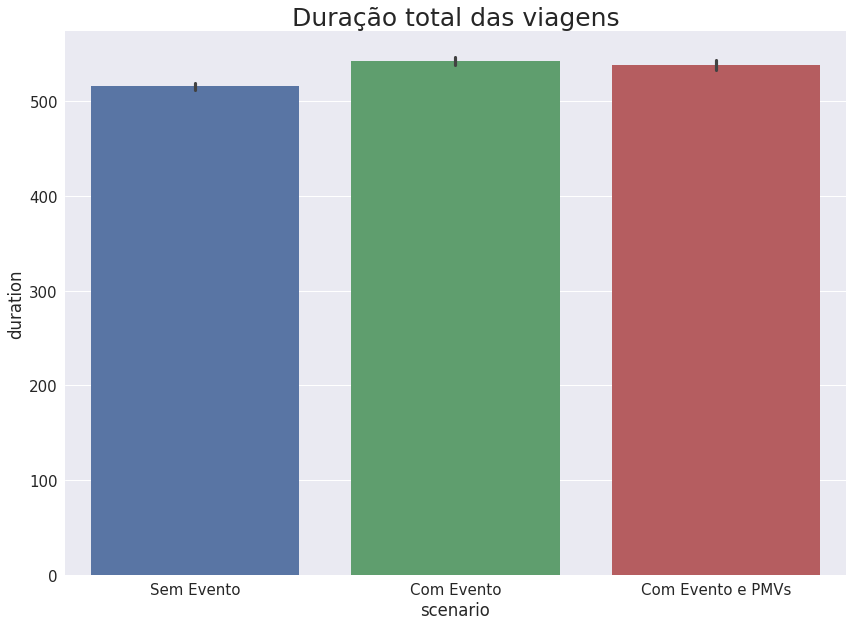

In [65]:
rc('text', usetex=False)

plt.figure(figsize=(14,10))

ax = sns.barplot(data=filtered_df, x='scenario', y='duration')

plt.legend(loc="best",prop={"size":20})
plt.title("Duração total das viagens", size=25)
sns.set(font_scale = 1.5)

plt.show()

Analisando a média das durações das viagens entre os três cenários vemos que o cenário sem eventos, dessa vez, foi o que apresentou as viagens mais rápidas, o que está de acordo com o que esperávamos. Por estarmos analisando só as viagens afetadas pelos fechamentos de vias, o fato das viagens estarem mais bem distribuídas (pelos PMVs) não compensou o fato das viagens utilizarem um caminho pior. Em resumo, ao analisar apenas as viagens afetadas o resultado foi condizente com o que foi levantado inicialmente. O cenário **sem eventos** é o nosso limite inferior, o **com eventos e sem PMVs** o limite superior, e a utilização de **PMVs** auxiliou no melhor fluxo dos carros em situação de fechamento de vias contudo não superando o cenário sem eventos.

A partir dos resultados, observamos os seguintes fatos:

- O cenário com eventos e PMVs apresenta viagens mais rápidas que o cenário com eventos e sem PMVs. O fato dos motoristas serem notificados que uma via está fechada previamente permite que um melhor planejamento do trajeto seja feito, proporcionando menor duração da viagem.

- O modelo utilizado não leva em conta o fluxo da via, de modo que o cenário com PMVs e eventos possa inclusive ter resultado melhor que sem eventos, já que a distribuição dos veículos será melhor.

Identificamos as seguintes limitações neste experimento:

- O modelo utilizado pelo simulador é passível de melhorias: o fato de não utilizar o fluxo de veículos na via no cálculo do caminho a ser utilizado dificulta a visualização do impacto do fechamento de rua

- Fatores externos (como qualidade da rede, recursos computacionais disponíveis, dentre outros) podem ter afetado os resultados

Com as discussões apresentadas, concluímos que:

- A utilização dos PMVs favorece o fluxo de veículos perante eventos de fechamento de vias, reduzindo em média x% do tempo de viagem. 